<a href="https://colab.research.google.com/github/guilhermebispo/nih-chestxray-label-validation/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==== Instalações (rápidas) ====
!pip -q install ipywidgets==8.1.1

# ==== Imports e paths ====
import os, random, pandas as pd, numpy as np, matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime

# Ajuste os caminhos conforme sua organização no Colab:
IMAGES_DIR = "/content/images"              # pasta com as imagens .png/.jpg
CSV_PATH   = "/content/sample_labels.csv"   # CSV NIH original (coluna 'Image Index' e 'Finding Labels')
OUTPUT_CSV = "/content/labels_experts.csv"  # arquivo de saída das anotações
SAMPLE_SIZE = 100                           # amostra (None ou um número)

os.makedirs(IMAGES_DIR, exist_ok=True)

# ==== Rótulos PT -> NIH ====
LABEL_MAP_PT2EN = {
    "Sem achado":                 "No Finding",
    "Atelectasia":                "Atelectasis",
    "Cardiomegalia":              "Cardiomegaly",
    "Derrame pleural":            "Effusion",
    "Infiltração":                "Infiltration",
    "Massa":                      "Mass",
    "Nódulo":                     "Nodule",
    "Pneumonia":                  "Pneumonia",
    "Pneumotórax":                "Pneumothorax",
    "Consolidação":               "Consolidation",
    "Edema":                      "Edema",
    "Enfisema":                   "Emphysema",
    "Fibrose":                    "Fibrosis",
    "Espessamento pleural":       "Pleural_Thickening",
    "Hérnia":                     "Hernia",
}
LABELS_PT = list(LABEL_MAP_PT2EN.keys())
LABELS_NIH = list(dict.fromkeys(LABEL_MAP_PT2EN.values()))  # preserva ordem

# ==== Carrega CSV NIH (para lista de arquivos e rótulo "oficial") ====
df_idx = pd.read_csv(CSV_PATH)
if "Image Index" not in df_idx.columns:
    raise ValueError("O CSV deve conter a coluna 'Image Index'.")
image_list = df_idx["Image Index"].astype(str).tolist()

# usa só imagens existentes na pasta
available = [f for f in image_list if os.path.exists(os.path.join(IMAGES_DIR, f))]
if not available:
    raise ValueError("Nenhuma imagem do CSV foi encontrada na pasta IMAGES_DIR.")

if SAMPLE_SIZE:
    random.seed(42)
    available = random.sample(available, min(SAMPLE_SIZE, len(available)))

print(f"Imagens disponíveis para rotular: {len(available)}")

# ==== Cria/Carrega arquivo de saída ====
cols_out = ["timestamp","especialista","crm","imagem","rotulos_pt","rotulos_nih","acao"]
if os.path.exists(OUTPUT_CSV):
    labeled = pd.read_csv(OUTPUT_CSV)
    for c in cols_out:
        if c not in labeled.columns:
            labeled[c] = ""
else:
    labeled = pd.DataFrame(columns=cols_out)

# ==== Helpers para análise (usados depois também) ====
def pt_to_en(pt_labels_list):
    """Converte lista de rótulos PT -> NIH (EN) e aplica regra de exclusividade do 'Sem achado'."""
    if not pt_labels_list:
        return []
    if "Sem achado" in pt_labels_list:
        return ["No Finding"]
    return [LABEL_MAP_PT2EN[l] for l in pt_labels_list]

def parse_dataset_labels_nih(labels_str):
    """Converte string NIH do dataset para lista (pipe-delimited), mantendo 'No Finding' se presente."""
    if pd.isna(labels_str) or not str(labels_str).strip():
        return []
    parts = [p.strip() for p in str(labels_str).split("|") if p.strip()]
    return parts

def multilabel_binarize(labels_list, classes):
    """Transforma lista de strings em vetor binário conforme 'classes'."""
    vec = np.zeros(len(classes), dtype=int)
    for i, c in enumerate(classes):
        if c in labels_list:
            vec[i] = 1
    return vec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.7 MB/s eta 0:00:00
Imagens disponíveis para rotular: 26


In [3]:
# ====== Widgets de identificação do especialista ======
w_name = widgets.Text(description="Especialista:", placeholder="Nome completo", layout=widgets.Layout(width='60%'))
w_crm  = widgets.Text(description="CRM:", placeholder="UF-000000", layout=widgets.Layout(width='40%'))
w_start = widgets.Button(description="Iniciar Rotulagem", button_style='primary')
w_info = widgets.HTML("<b>Preencha seus dados e clique em Iniciar.</b>")

display(w_info, widgets.HBox([w_name, w_crm]), w_start)

# ====== Widgets de anotação ======
w_multi = widgets.SelectMultiple(
    options=LABELS_PT,
    value=(),
    description='Patologias:',
    layout=widgets.Layout(width='50%', height='240px')
)
w_save = widgets.Button(description="Salvar e Próxima", button_style='success')
w_skip = widgets.Button(description="Pular", button_style='warning')
w_unknown = widgets.Button(description="Indefinido", button_style='')
w_quit = widgets.Button(description="Encerrar", button_style='danger')
w_status = widgets.Label()

state = {"started": False, "index": 0, "queue": available.copy()}

def already_labeled(img, esp, crm):
    if labeled.empty:
        return False
    sub = labeled[(labeled["imagem"]==img) & (labeled["especialista"]==esp) & (labeled["crm"]==crm)]
    return len(sub) > 0

def show_image(idx):
    clear_output(wait=True)
    display(w_info, widgets.HTML(
        f"<b>Especialista:</b> {w_name.value} &nbsp;&nbsp; <b>CRM:</b> {w_crm.value} "
        f"&nbsp;&nbsp; <b>Imagem:</b> {state['queue'][idx]} "
        f"({idx+1}/{len(state['queue'])})"
    ))
    img_path = os.path.join(IMAGES_DIR, state["queue"][idx])
    img = plt.imread(img_path)
    plt.figure(figsize=(6.5,6.5))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(state["queue"][idx])
    plt.show()
    display(w_multi, widgets.HBox([w_save, w_skip, w_unknown, w_quit]), w_status)

def ensure_started(_=None):
    name = w_name.value.strip()
    crm  = w_crm.value.strip()
    if not name or not crm:
        w_info.value = "<span style='color:#d00'><b>Informe nome e CRM para começar.</b></span>"
        return
    state["started"] = True
    w_info.value = "<b>Rotulagem em andamento.</b> Selecione as patologias e clique em <i>Salvar e Próxima</i>."
    state["index"] = 0
    # pular imagens já rotuladas por este especialista
    while state["index"] < len(state["queue"]) and already_labeled(state["queue"][state["index"]], name, crm):
        state["index"] += 1
    if state["index"] >= len(state["queue"]):
        clear_output()
        print("Nada a rotular — este especialista já rotulou todas as imagens desta amostra.")
        return
    show_image(state["index"])

def append_row(img, labels_pt, action):
    labels_pt = list(labels_pt)
    if "Sem achado" in labels_pt:
        labels_pt = ["Sem achado"]
    labels_nih = pt_to_en(labels_pt)
    row = {
        "timestamp": datetime.utcnow().isoformat(),
        "especialista": w_name.value.strip(),
        "crm": w_crm.value.strip(),
        "imagem": img,
        "rotulos_pt": "|".join(labels_pt) if labels_pt else "",
        "rotulos_nih": "|".join(labels_nih) if labels_nih else "",
        "acao": action  # SAVE / SKIP / UNKNOWN
    }
    global labeled
    labeled = pd.concat([labeled, pd.DataFrame([row])], ignore_index=True)
    labeled.to_csv(OUTPUT_CSV, index=False)

def save_and_next(_):
    if not state["started"]: return
    labels_pt = list(w_multi.value)
    img = state["queue"][state["index"]]
    append_row(img, labels_pt, "SAVE")
    w_status.value = f"✅ Salvo: {img}"
    state["index"] += 1
    while state["index"] < len(state["queue"]) and already_labeled(state["queue"][state["index"]], w_name.value.strip(), w_crm.value.strip()):
        state["index"] += 1
    if state["index"] < len(state["queue"]):
        w_multi.value = ()
        show_image(state["index"])
    else:
        clear_output()
        print("✅ Fim da amostra. Salvo em:", OUTPUT_CSV)

def skip_image(_):
    if not state["started"]: return
    img = state["queue"][state["index"]]
    append_row(img, [], "SKIP")
    w_status.value = f"⏭️ Pulado: {img}"
    state["index"] += 1
    while state["index"] < len(state["queue"]) and already_labeled(state["queue"][state["index"]], w_name.value.strip(), w_crm.value.strip()):
        state["index"] += 1
    if state["index"] < len(state["queue"]):
        w_multi.value = ()
        show_image(state["index"])
    else:
        clear_output()
        print("✅ Fim da amostra. Salvo em:", OUTPUT_CSV)

def unknown_image(_):
    if not state["started"]: return
    img = state["queue"][state["index"]]
    append_row(img, [], "UNKNOWN")
    w_status.value = f"❓ Indefinido: {img}"
    state["index"] += 1
    while state["index"] < len(state["queue"]) and already_labeled(state["queue"][state["index"]], w_name.value.strip(), w_crm.value.strip()):
        state["index"] += 1
    if state["index"] < len(state["queue"]):
        w_multi.value = ()
        show_image(state["index"])
    else:
        clear_output()
        print("✅ Fim da amostra. Salvo em:", OUTPUT_CSV)

def quit_session(_):
    clear_output()
    labeled.to_csv(OUTPUT_CSV, index=False)
    print("🛑 Sessão encerrada. Progresso salvo em:", OUTPUT_CSV)

# binds
w_start.on_click(ensure_started)
w_save.on_click(save_and_next)
w_skip.on_click(skip_image)
w_unknown.on_click(unknown_image)
w_quit.on_click(quit_session)


🛑 Sessão encerrada. Progresso salvo em: /content/labels_experts.csv


In [4]:
# ===== Carrega anotações e rótulos do dataset =====
ann = pd.read_csv(OUTPUT_CSV) if os.path.exists(OUTPUT_CSV) else pd.DataFrame(columns=cols_out)

# Considera apenas ações efetivas de rótulo
ann_use = ann[ann["acao"].isin(["SAVE"])].copy()

# GROUND TRUTH (dataset)
gt = df_idx[["Image Index", "Finding Labels"]].rename(columns={"Image Index":"imagem"})
gt["labels_nih"] = gt["Finding Labels"].apply(parse_dataset_labels_nih)
gt["has_any_finding"] = gt["labels_nih"].apply(lambda labs: 0 if ("No Finding" in labs and len(labs)==1) else (0 if labs==[] else 1))

# ===== Agregação por maioria (majority vote) =====
from collections import Counter, defaultdict

def majority_vote(labels_lists, classes, tie_policy="keep_ties"):
    """
    labels_lists: lista de listas (cada lista = rótulos NIH do especialista)
    classes: lista com o conjunto de classes (NIH_LABELS)
    Retorna: lista de classes vencedoras (pode haver mais de uma em caso de empate).
    Regras:
      - 'No Finding' é exclusivo: se maioria escolher 'No Finding', retorna somente ele.
      - senão, considera contagem por classe e inclui as > floor(n/2). se nenhuma > metade,
        aplica 'keep_ties' (pode retornar múltiplas empatadas com max) ou retorna vazio.
    """
    if not labels_lists:
        return []
    n = len(labels_lists)
    # normaliza (garante regra de exclusividade por anotação)
    normed = []
    for labs in labels_lists:
        labs = labs or []
        if "No Finding" in labs:
            normed.append(["No Finding"])
        else:
            normed.append(labs)
    # contagem
    counts = Counter()
    for labs in normed:
        for l in labs:
            counts[l] += 1
    # maioria absoluta de 'No Finding'
    if counts["No Finding"] > n // 2:
        return ["No Finding"]
    # seleciona classes com contagem > n/2
    maj = [c for c in classes if counts[c] > n//2 and c != "No Finding"]
    if maj:
        return maj
    # se ninguém > metade, adota política de empate
    if tie_policy == "keep_ties":
        if counts:
            maxv = max(counts[c] for c in classes)
            tied = [c for c in classes if counts[c] == maxv]
            # se 'No Finding' estiver empatado com outras patologias, removemos 'No Finding'
            if "No Finding" in tied and len(tied) > 1:
                tied = [c for c in tied if c != "No Finding"]
            return tied
    return []

# consolida anotações por imagem
by_img = defaultdict(list)
for _, row in ann_use.iterrows():
    labs = [] if pd.isna(row["rotulos_nih"]) or row["rotulos_nih"]=="" else row["rotulos_nih"].split("|")
    by_img[row["imagem"]].append(labs)

maj_rows = []
for img, lists_ in by_img.items():
    mv = majority_vote(lists_, LABELS_NIH)
    maj_rows.append({"imagem": img, "maj_labels": mv, "maj_any_finding": 0 if (mv==["No Finding"]) else (0 if len(mv)==0 else 1)})

maj = pd.DataFrame(maj_rows)

# ===== Junta com ground truth e calcula métricas =====
eval_df = gt.merge(maj, on="imagem", how="inner")  # apenas imagens com maioria
print(f"Imagens com maioria calculada: {len(eval_df)}")

from sklearn.metrics import confusion_matrix, classification_report

# Binário: AnyFinding (dataset) vs AnyFinding (majority)
y_true = eval_df["has_any_finding"].values
y_pred = eval_df["maj_any_finding"].values

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
acc = (tp+tn)/cm.sum() if cm.sum() else np.nan
prec = tp/(tp+fp) if (tp+fp)>0 else np.nan
rec = tp/(tp+fn) if (tp+fn)>0 else np.nan
f1 = 2*prec*rec/(prec+rec) if (prec>0 and rec>0) else np.nan

print("=== Matriz de confusão (AnyFinding) ===")
print(pd.DataFrame(cm, index=["GT:Sem achado","GT:Patologia"], columns=["Pred:Sem achado","Pred:Patologia"]))
print(f"\nAcurácia: {acc:.3f}  Precisão: {prec:.3f}  Revocação: {rec:.3f}  F1: {f1:.3f}")

# ===== Multirrótulo por patologia (exclui No Finding) =====
# Constrói vetores multilabel (dataset vs majority) nas 14 patologias NIH (sem No Finding)
patho_classes = [c for c in LABELS_NIH if c != "No Finding"]

Y_true = np.vstack([multilabel_binarize([l for l in labs if l!="No Finding"], patho_classes)
                    for labs in eval_df["labels_nih"]])
Y_pred = np.vstack([multilabel_binarize([l for l in labs if l!="No Finding"], patho_classes)
                    for labs in eval_df["maj_labels"]])

# Relatório (macro/micro)
report = classification_report(Y_true, Y_pred, target_names=patho_classes, zero_division=0, output_dict=True)
rep_df = pd.DataFrame(report).T
print("\n=== Relatório por patologia (NIH) — majority vs dataset ===")
display(rep_df.round(3))

# ===== Acordo entre especialistas (AnyFinding) =====
# Converte cada anotação para binário AnyFinding e mede concordância percentual média por imagem
def anyfinding_from_list(labs):
    if not labs: return 0
    return 0 if (labs==["No Finding"]) else 1

agree_list = []
n_raters = []
for img, lists_ in by_img.items():
    # ignora listas vazias (não anotadas)
    votes = [anyfinding_from_list(l) for l in lists_ if l is not None]
    if len(votes) >= 2:
        n = len(votes)
        prop_1 = sum(votes)/n
        # acordo percentual = fração do voto majoritário
        maj_count = max(sum(votes), n - sum(votes))
        agree = maj_count / n
        agree_list.append(agree)
        n_raters.append(n)

if agree_list:
    print(f"\nAcordo médio entre especialistas (AnyFinding): {np.mean(agree_list):.3f}")
    print(f"Nº médio de avaliadores por imagem: {np.mean(n_raters):.2f}")
else:
    print("\nAinda não há anotações suficientes (>=2 por imagem) para estimar acordo entre especialistas.")


Imagens com maioria calculada: 7
=== Matriz de confusão (AnyFinding) ===
               Pred:Sem achado  Pred:Patologia
GT:Sem achado                0               1
GT:Patologia                 0               6

Acurácia: 0.857  Precisão: 0.857  Revocação: 1.000  F1: 0.923

=== Relatório por patologia (NIH) — majority vs dataset ===


,precision,recall,f1-score,support
Atelectasis,0.0,0.0,0.0,1.0
Cardiomegaly,0.0,0.0,0.0,2.0
Effusion,0.0,0.0,0.0,2.0
Infiltration,0.0,0.0,0.0,1.0
Mass,0.0,0.0,0.0,0.0
Nodule,0.0,0.0,0.0,0.0
Pneumonia,0.0,0.0,0.0,0.0
Pneumothorax,0.0,0.0,0.0,1.0
Consolidation,0.0,0.0,0.0,2.0
Edema,0.0,0.0,0.0,1.0



Ainda não há anotações suficientes (>=2 por imagem) para estimar acordo entre especialistas.


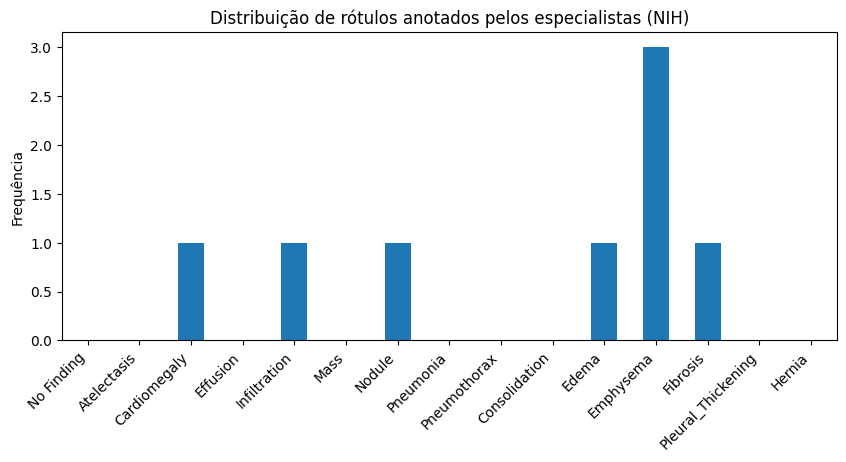

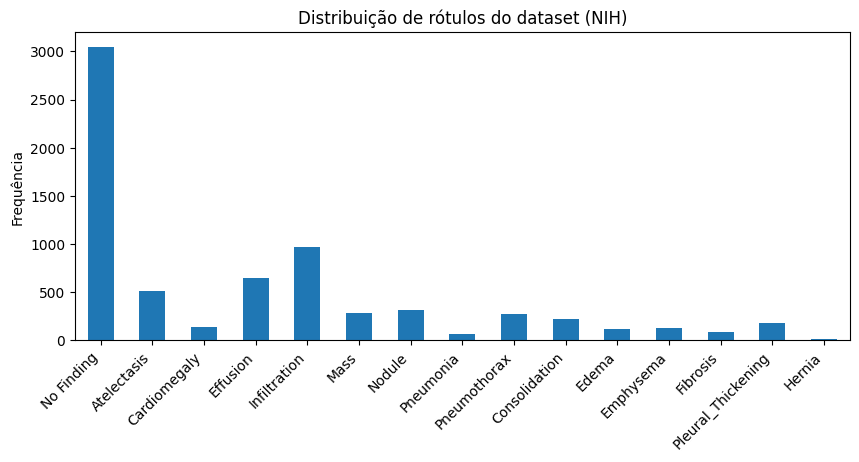

In [5]:
# Distribuição de votos por patologia (anotações)
if not ann_use.empty:
    all_labels = []
    for s in ann_use["rotulos_nih"].fillna(""):
        if s.strip():
            all_labels += s.split("|")
    counts = pd.Series(all_labels).value_counts().reindex(LABELS_NIH, fill_value=0)
    plt.figure(figsize=(10,4))
    counts.plot(kind="bar")
    plt.title("Distribuição de rótulos anotados pelos especialistas (NIH)")
    plt.ylabel("Frequência")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# Distribuição do ground truth (dataset)
gt_all = []
for labs in gt["labels_nih"]:
    gt_all += labs
gt_counts = pd.Series(gt_all).value_counts().reindex(LABELS_NIH, fill_value=0)
plt.figure(figsize=(10,4))
gt_counts.plot(kind="bar")
plt.title("Distribuição de rótulos do dataset (NIH)")
plt.ylabel("Frequência")
plt.xticks(rotation=45, ha="right")
plt.show()
